# Importing Libraries

In [1]:
!pip install geneticalgorithm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 754.0 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for func-timeout: filename=func_timeout-4.3.5-py3-none-any.whl size=15080 sha256=eeb6ea6574ef7ec0853b5b9c75efee08d5a68b2c547b951b44751ee993905d55
  Stored in directory: /root/.cache/pip/wheels/3f/83/19/b5552bb9630e353f7c5b15be44bf10900afe1abbbfcf536afd
Successfully built func-timeout


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.image as mpimg
import cv2
from tqdm import tqdm
from tensorflow.keras.applications import MobileNetV2
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from geneticalgorithm import geneticalgorithm as ga
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Define the paths
train_path = '/kaggle/input/facial-emotions-recognition-dataset/facial emotion recognition/train'
validation_path = '/kaggle/input/facial-emotions-recognition-dataset/facial emotion recognition/validation'
test_path = '/kaggle/input/facial-emotions-recognition-dataset/facial emotion recognition/test'

In [4]:
# Define the data generator for training
train_datagen = ImageDataGenerator(rescale=1./255)

# Define the data generator for validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Define the data generator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the training data generator with validation split
train_data = train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(128, 128),
    batch_size=32,
    shuffle=True  # Shuffle the training data
)

# Create the validation data generator
validation_data = validation_datagen.flow_from_directory(
    directory=validation_path,
    target_size=(128, 128),
    batch_size=32,
    shuffle=False  # Do not shuffle the validation data
)

# Create the test data generator
test_data = test_datagen.flow_from_directory(
    directory=test_path,
    target_size=(128, 128),
    batch_size=32,
    shuffle=False  # Ensure the order of predictions matches the order of the files
)

# Print class indices for reference
print("Class Indices:", train_data.class_indices)

Found 28704 images belonging to 7 classes.
Found 3588 images belonging to 7 classes.
Found 3595 images belonging to 7 classes.
Class Indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [5]:
# Print the shape of the data
print("Training Generator Shape:", train_data.image_shape)
print("Validation Generator Shape:", validation_data.image_shape)
print("Validation Generator Shape:", test_data.image_shape)
print (train_data.classes)
print (test_data.classes)

Training Generator Shape: (128, 128, 3)
Validation Generator Shape: (128, 128, 3)
Validation Generator Shape: (128, 128, 3)
[0 0 0 ... 6 6 6]
[0 0 0 ... 6 6 6]


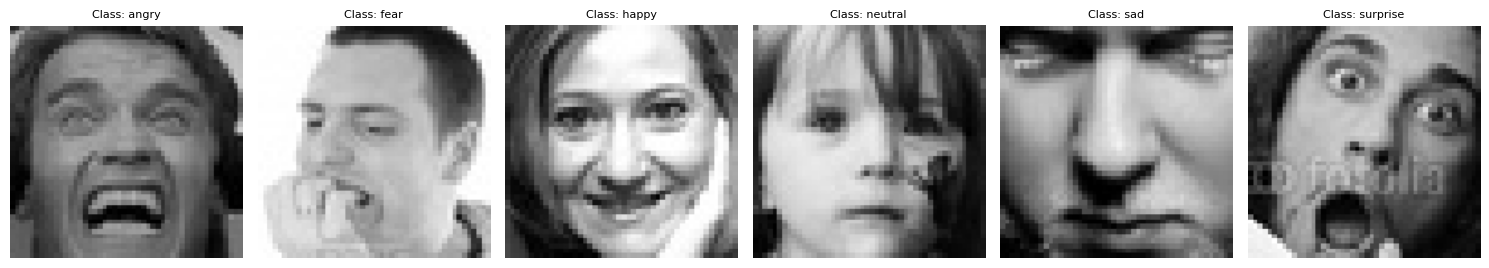

In [6]:
# Get a batch of images from the generator
images, labels = train_data.next()

# Get unique class indices
unique_classes = np.unique(labels.argmax(axis=1))

# Display one image per class in a single row
plt.figure(figsize=(15, 3))
for i, class_idx in enumerate(unique_classes):
    # Find the index of the first image with the current class
    image_idx = np.where(labels.argmax(axis=1) == class_idx)[0][0]

    plt.subplot(1, len(unique_classes), i+1)
    plt.imshow(images[image_idx])
    plt.title(f"Class: {list(train_data.class_indices.keys())[class_idx]}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Model without the Optimizer

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

# Load ResNet50 pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adjust the dropout rate based on your needs
model.add(Dense(7, activation='softmax'))  # Set num_classes to the number of classes in your dataset

# Compile the model with a learning rate schedule
initial_learning_rate = 0.001
model.compile(optimizer=Adam(lr=initial_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# Set up a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Print the summary of the model
model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                         

In [8]:
# Train the model using fit_generator
history = model.fit_generator(
    generator=train_data,
    epochs=30,
    validation_data=validation_data,  # Use the same generator for validation
    steps_per_epoch=len(train_data),
    validation_steps=len(validation_data),  # Use the same steps as for training
)

Epoch 1/30


/tmp/ipykernel_42/1261486385.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


897/897 [==============================] - 132s 134ms/step - loss: 1.7033 - accuracy: 0.3207 - val_loss: 1.6226 - val_accuracy: 0.3512
Epoch 2/30
897/897 [==============================] - 39s 43ms/step - loss: 1.6222 - accuracy: 0.3611 - val_loss: 1.5827 - val_accuracy: 0.3807
Epoch 3/30
897/897 [==============================] - 40s 44ms/step - loss: 1.5915 - accuracy: 0.3758 - val_loss: 1.5617 - val_accuracy: 0.3838
Epoch 4/30
897/897 [==============================] - 39s 44ms/step - loss: 1.5691 - accuracy: 0.3872 - val_loss: 1.5541 - val_accuracy: 0.3877
Epoch 5/30
897/897 [==============================] - 39s 44ms/step - loss: 1.5516 - accuracy: 0.3933 - val_loss: 1.5394 - val_accuracy: 0.3972
Epoch 6/30
897/897 [==============================] - 39s 44ms/step - loss: 1.5332 - accuracy: 0.4023 - val_loss: 1.5367 - val_accuracy: 0.4011
Epoch 7/30
897/897 [==============================] - 39s 44ms/step - loss: 1.5160 - accuracy: 0.4110 - val_loss: 1.5247 - val_accuracy: 0.4027
E

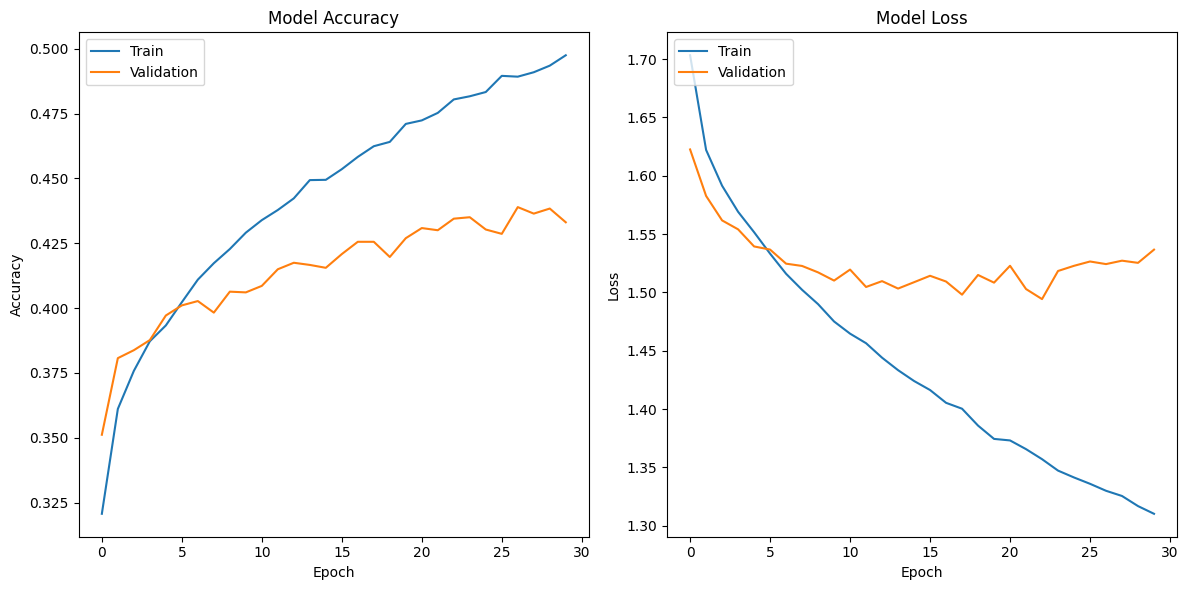

In [9]:
# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

## Prediciton

113/113 [==============================] - 18s 155ms/step


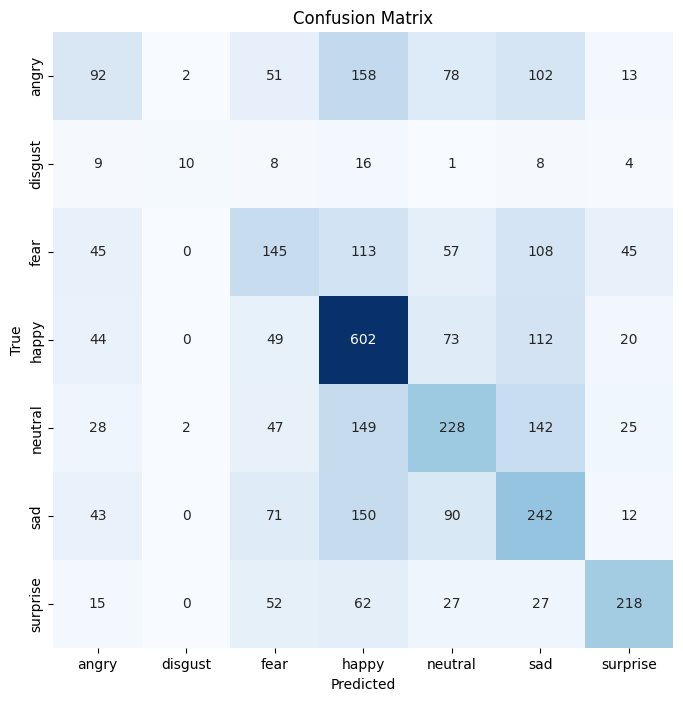

Weighted Precision: 0.4250801391986787
Weighted Recall: 0.42753824756606396
Weighted F1-Score: 0.41535654226936336
Overall Accuracy: 0.42753824756606396


In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

# Step 1: Make Predictions
predictions = model.predict(test_data, steps=len(test_data))

# Step 2: Convert Predictions to Class Labels
predicted_labels = np.argmax(predictions, axis=1)

# Step 3: Create Confusion Matrix
true_labels = test_data.classes

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Calculate and Print Metrics
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-Score:", f1)
print("Overall Accuracy:", accuracy)

# Model with Genetic Optimizer

In [7]:
from keras.applications import ResNet50

# Load ResNet50 pretrained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Print the summary of the model
base_model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

# Extract features from the pre-trained MobileNet model
train_features = base_model.predict(train_data)
test_features = base_model.predict(test_data)

# Flatten features
train_features = train_features.reshape(train_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

# Get labels for the samples
train_labels = train_data.classes
test_labels = test_data.classes  # Added this line to get test labels

# Ensure the labels have all classes in the dataset
unique_classes_train = np.unique(train_labels)
unique_classes_test = np.unique(test_labels)

# Select the first 5% of samples for both training and test sets, ensuring all classes are included
selected_indices_train = []
for class_label in unique_classes_train:
    class_indices = np.where(train_labels == class_label)[0]
    selected_indices_train.extend(class_indices[:int(0.10 * len(class_indices))])

selected_indices_test = []
for class_label in unique_classes_test:
    class_indices = np.where(test_labels == class_label)[0]
    selected_indices_test.extend(class_indices[:int(0.10 * len(class_indices))])

train_features = train_features[selected_indices_train, :]
train_labels = train_labels[selected_indices_train]

test_features = test_features[selected_indices_test, :]
test_labels = test_labels[selected_indices_test]

113/113 [==============================] - 13s 117ms/step


In [9]:
# Set a random seed for reproducibility
random_state = 42  # You can use any integer value as the seed
np.random.seed(random_state)

# Shuffle the training data
shuffle_indices_train = np.random.permutation(len(train_labels))
train_features = train_features[shuffle_indices_train, :]
train_labels = train_labels[shuffle_indices_train]

# Shuffle the test data
shuffle_indices_test = np.random.permutation(len(test_labels))
test_features = test_features[shuffle_indices_test, :]
test_labels = test_labels[shuffle_indices_test]

In [10]:
print("Train Features Shape:", train_features.shape)
print("Test Features Shape:", train_labels.shape)

Train Features Shape: (2868, 32768)
Test Features Shape: (2868,)


In [11]:
print("Train Features Shape:", test_features.shape)
print("Test Features Shape:", test_labels.shape)

Train Features Shape: (357, 32768)
Test Features Shape: (357,)


In [12]:
print(np.unique(train_labels))
print(np.unique(test_labels))

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


In [13]:
global_train_features = train_features
global_test_features = test_features

In [14]:
def fitness(X):
    train_features = global_train_features  # Access train_features from a global scope or another method
    test_features = global_test_features  # Access test_features from a global scope or another method

    selected_features = [i for i in range(len(X)) if X[i] > 0.5]  # Binary mask to select features
    if len(selected_features) == 0:
        return 0.0

    selected_train_features = train_features[:, selected_features]
    selected_test_features = test_features[:, selected_features]

    # Use SVM classifier on the selected features
    clf = SVC(kernel='linear')  # Use SVM with linear kernel
    clf.fit(selected_train_features, train_labels)
    predictions = clf.predict(selected_test_features)
    accuracy = accuracy_score(test_labels, predictions)
    print(accuracy)
    return -accuracy  # Minimize negative accuracy for maximization problem

In [15]:
# Define the optimization problem (number of features to select)
varbound = np.array([[0, 1]] * train_features.shape[1])  # Binary mask for each feature

algorithm_param = {'max_num_iteration': 5,
                   'population_size': 20,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01, 
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

0.23529411764705882
0.23249299719887956
0.16806722689075632
0.22128851540616246
0.20168067226890757
0.21288515406162464
0.226890756302521
0.23249299719887956
0.19047619047619047
0.2184873949579832
0.24089635854341737
0.23249299719887956
0.24649859943977592
0.19047619047619047
0.21568627450980393
0.21288515406162464
0.226890756302521
0.21288515406162464
0.20728291316526612
||||||||||________________________________________ 20.0% GA is running...0.226890756302521
0.24929971988795518
0.22969187675070027
0.23809523809523808
0.2184873949579832
0.22969187675070027
0.22408963585434175
0.21568627450980393
0.22408963585434175
0.22128851540616246
0.226890756302521
0.226890756302521
0.21288515406162464
0.226890756302521
||||||||||||||||||||______________________________ 40.0% GA is running...0.226890756302521
0.21568627450980393
0.21008403361344538
0.21008403361344538
0.21288515406162464
0.20448179271708683
0.21568627450980393
0.22969187675070027
0.22408963585434175
0.22128851540616246
0.22969187

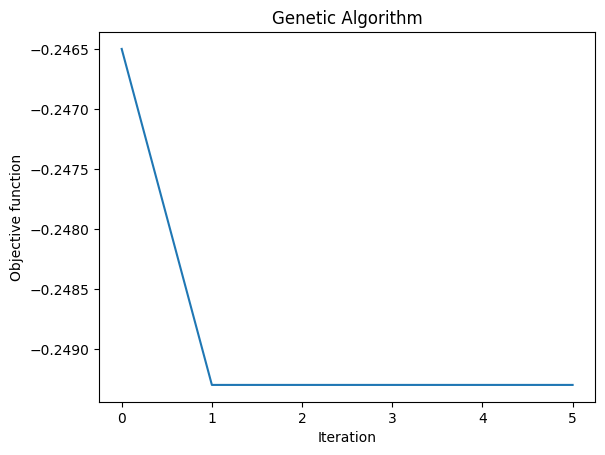

In [16]:
# Create the genetic algorithm instance
model = ga(function=fitness, dimension=train_features.shape[1], variable_type='bool', variable_boundaries=varbound,
           algorithm_parameters=algorithm_param, function_timeout = 60*60*7)

# Run the genetic algorithm
model.run()

In [17]:
# Get the best solution (selected features)
best_solution = model.output_dict['variable']
selected_indices = [i for i in range(len(best_solution)) if best_solution[i] > 0.5]

In [32]:
len(selected_indices)

16318

In [18]:
selected_train_features = train_features[:, selected_indices]
selected_train_labels = train_labels[:]  # Assuming labels are to be selected in the same way as features

selected_test_features = test_features[:, selected_indices]
selected_test_labels = test_labels[:]  # Assuming labels are to be selected in the same way as features

clf = SVC(kernel='linear')
clf.fit(selected_train_features, selected_train_labels.ravel())
predictions = clf.predict(selected_test_features)
accuracy = accuracy_score(selected_test_labels.ravel(), predictions)

print("Selected Features:", selected_indices)
print("Accuracy with selected features (using SVM classifier):", accuracy)

Selected Features: [0, 1, 4, 7, 10, 12, 14, 15, 16, 18, 19, 21, 22, 25, 27, 28, 29, 30, 32, 34, 36, 37, 38, 44, 45, 46, 49, 52, 54, 56, 57, 60, 62, 63, 64, 67, 72, 73, 77, 78, 79, 80, 81, 82, 87, 89, 90, 91, 92, 94, 95, 96, 97, 99, 100, 102, 104, 108, 113, 114, 116, 119, 120, 121, 122, 124, 127, 132, 133, 134, 136, 137, 138, 142, 143, 145, 146, 147, 148, 149, 150, 153, 155, 156, 157, 159, 160, 162, 164, 166, 169, 173, 174, 175, 176, 182, 183, 184, 185, 186, 187, 188, 191, 192, 193, 194, 195, 205, 208, 210, 212, 213, 216, 217, 218, 219, 220, 222, 224, 225, 227, 230, 235, 236, 237, 238, 240, 244, 245, 246, 247, 249, 250, 251, 253, 255, 257, 259, 263, 264, 266, 267, 269, 270, 271, 274, 276, 277, 278, 279, 282, 285, 288, 289, 292, 293, 296, 298, 301, 302, 304, 307, 309, 310, 311, 313, 314, 321, 325, 326, 327, 329, 330, 332, 333, 334, 338, 339, 341, 344, 345, 346, 347, 349, 352, 353, 355, 357, 359, 360, 361, 362, 364, 373, 376, 385, 387, 389, 393, 402, 404, 405, 407, 410, 412, 415, 416, 417

# Model Evaluation:


Weighted Average Precision: 0.21
Weighted Average Recall: 0.25
Weighted Average F1-Score: 0.19


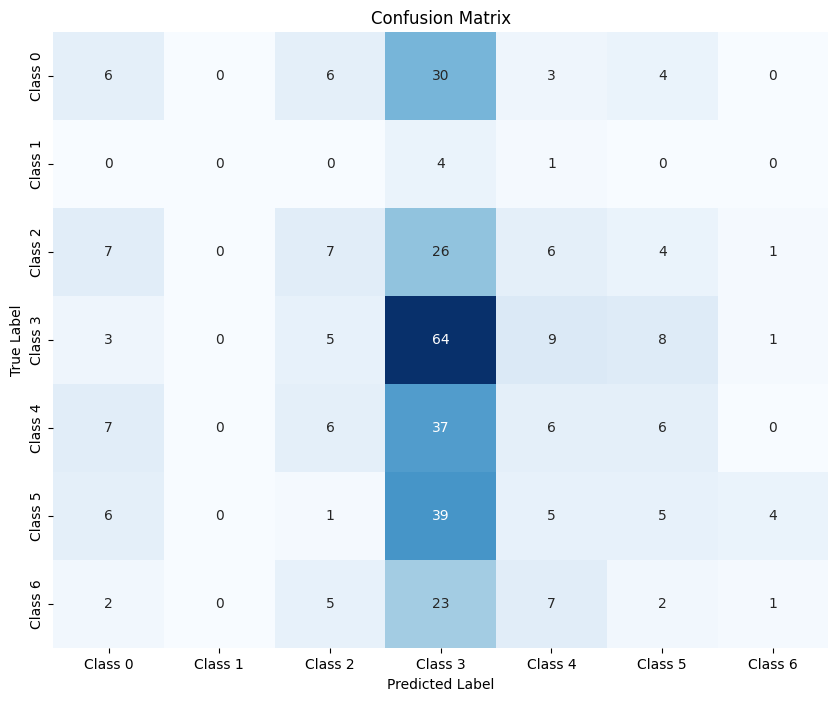

In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Classification Report
class_report = classification_report(selected_test_labels.ravel(), predictions, output_dict=True, zero_division=0)

# Print Total Scores
total_precision = class_report['weighted avg']['precision']
total_recall = class_report['weighted avg']['recall']
total_f1_score = class_report['weighted avg']['f1-score']

print(f"Weighted Average Precision: {total_precision:.2f}")
print(f"Weighted Average Recall: {total_recall:.2f}")
print(f"Weighted Average F1-Score: {total_f1_score:.2f}")

# Print Confusion Matrix
conf_matrix = confusion_matrix(selected_test_labels.ravel(), predictions)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
